🛰️ Green Area Analyzer using Google Earth Engine & Machine Learning
==================================================================

📌 Project Overview:
This notebook is designed to monitor and forecast vegetation trends by analyzing NDVI (Normalized Difference Vegetation Index) over time using satellite imagery from the Sentinel-2 dataset, accessed via the Google Earth Engine API.

The tool processes satellite images for a user-defined region and time period, extracts NDVI values, and uses various regression models to predict the greenness of that area in future years. It supports trend visualization and comparative analysis using multiple ML models.

🌿 Use Case:
This project is useful for environmental monitoring, deforestation tracking, agricultural assessment, and climate change studies. It provides a simple pipeline to understand how green cover is changing and how it might evolve in the coming years.

--------------------------------------------------------
🧠 Machine Learning Models Used:
--------------------------------------------------------
1. Random Forest Regressor (Robust and interpretable)
2. Support Vector Regressor (Works well with nonlinear data)
3. Gradient Boosting Regressor (Accurate, slow but powerful)
4. Decision Tree Regressor (Simple and fast)
5. XGBoost Regressor (Optimized and scalable boosting)

--------------------------------------------------------
📦 Python Libraries Required:
--------------------------------------------------------
- earthengine-api: Interface to Google Earth Engine
- numpy: Array manipulation
- pandas: Dataframe operations
- matplotlib: Data visualization
- scikit-learn: Machine learning algorithms
- xgboost: Gradient boosting model
- mpl_toolkits.axes_grid1: Advanced plotting (included with matplotlib)

--------------------------------------------------------
🛠️ Workflow:
--------------------------------------------------------
1. Authenticate and initialize the Earth Engine API.
2. Select location coordinates (latitude-longitude bounding box).
3. Fetch Sentinel-2 imagery filtered by date and cloud coverage.
4. Compute NDVI from bands B8 (NIR) and B4 (Red).
5. Store NDVI data with timestamps.
6. Train multiple regression models on historical NDVI data.
7. Predict NDVI values for future time frames.
8. Plot original data, fitted model, and forecasted trend.
9. Automatically classify the vegetation trend (increasing/decreasing).

--------------------------------------------------------
📅 Parameters:
--------------------------------------------------------
- `locations`: Dictionary with region names and bounding box coordinates.
- `train_years`: Number of years to train the model on historical data.
- `predict_years`: Number of years to forecast into the future.

--------------------------------------------------------
📍 Example Use:
--------------------------------------------------------
- Analyzing forest greenness over the Amazon basin from 2019–2025.
- Predicting NDVI trends to monitor possible deforestation or seasonal variation.
- Comparing the performance of different ML models for environmental forecasting.

--------------------------------------------------------
👨‍💻 Author: Chinmay Bansal
📅 Year: 2025

In [ ]:
%pip install earthengine-api numpy pandas matplotlib scikit-learn xgboost
%pip install --upgrade xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.9 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [11]:
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import mpl_toolkits.axes_grid1

In [12]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project='satellite-454512')

In [13]:
class GreenAreaAnalyzer:
    def __init__(self, locations, train_years=5, predict_years=2):
        self.locations = locations
        self.train_years = train_years
        self.predict_years = predict_years

    def fetch_and_calculate_ndvi(self, name, coords, start_date, end_date):
        area_of_interest = ee.Geometry.Rectangle([coords[1], coords[0], coords[3], coords[2]])
        collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                      .filterBounds(area_of_interest)
                      .filterDate(start_date, end_date)
                      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
                      .select(['B8', 'B4']))
        images = collection.toList(collection.size()).getInfo()

        if len(images) == 0:
            print(f"No images found for {name} in the given date range.")
            return name, pd.DataFrame()

        ndvi_values, dates = [], []
        for image_info in images:
            image = ee.Image(image_info['id'])
            timestamp = image_info['properties']['system:time_start'] / 1000
            date = datetime.fromtimestamp(timestamp)
            ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
            result = ndvi.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=area_of_interest,
                scale=30,
                maxPixels=1e13
            ).getInfo()
            ndvi_value = result.get('NDVI')
            if ndvi_value is not None:
                ndvi_values.append(float(ndvi_value))
                dates.append(date)

        return name, pd.DataFrame({'Date': dates, 'NDVI': ndvi_values})

    def analyze_sequential(self, start_date, end_date):
        results = {}
        for loc in self.locations.items():
            name, data = self.fetch_and_calculate_ndvi(loc[0], loc[1], start_date, end_date)
            results[name] = data
        return results

    def plot_and_predict(self):
        base_year = 2019
        train_start_date = datetime(base_year, 1, 1).strftime('%Y-%m-%d')
        train_end_date = datetime(base_year + self.train_years, 1, 1).strftime('%Y-%m-%d')
        predict_end_date = datetime(base_year + self.train_years + self.predict_years, 1, 1).strftime('%Y-%m-%d')

        results = self.analyze_sequential(train_start_date, train_end_date)
        actual_future_results = self.analyze_sequential(train_end_date, predict_end_date)

        regressors = {
            'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
            'SVR': SVR(),
            'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
            'DecisionTree': DecisionTreeRegressor(random_state=42),
            'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
        }

        for name, df in results.items():
            if df.empty:
                print(f"No data available for {name}.")
                continue

            df['Timestamp'] = pd.to_datetime(df['Date']).astype('int64') / 10**9
            X = df['Timestamp'].values.reshape(-1, 1)
            y = df['NDVI'].values.reshape(-1, 1)

            scaler_X = StandardScaler()
            scaler_y = StandardScaler()
            X_scaled = scaler_X.fit_transform(X)
            y_scaled = scaler_y.fit_transform(y)

            future_dates = pd.date_range(start=train_end_date, end=predict_end_date, freq='ME')
            future_timestamps = (future_dates - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
            future_timestamps = np.array(future_timestamps).reshape(-1, 1)
            future_timestamps_scaled = scaler_X.transform(future_timestamps)

            n_rows = len(regressors)
            fig, axs = plt.subplots(n_rows, 2, figsize=(20, 6 * n_rows), squeeze=False)

            train_trend = 'increasing' if y[-1][0] > y[0][0] else 'decreasing'
            print(f"🌿 Greenery Trend for {name} based on Training Data: {train_trend}")

            for i, (reg_name, regressor) in enumerate(regressors.items()):
                regressor.fit(X_scaled, y_scaled.ravel())

                ax = axs[i, 0]
                ax.scatter(df['Date'], y.flatten(), color='blue', label='Actual NDVI', s=30)

                fitted = scaler_y.inverse_transform(
                    regressor.predict(X_scaled).reshape(-1, 1)
                ).flatten()
                ax.plot(df['Date'], fitted, color='orange', label='Fitted NDVI', linewidth=1.5)

                predictions_scaled = regressor.predict(future_timestamps_scaled)
                predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()

                ax.plot(future_dates, predictions, color='green', label='Predicted NDVI', linewidth=1.5)
                ax.set_title(f'{reg_name} - {name}')
                ax.legend()
                ax.grid(True)

                trend = 'increasing' if predictions[-1] > predictions[0] else 'decreasing'

                ax2 = axs[i, 1]
                ax2.plot(future_dates, predictions,
                         color='green' if trend == 'increasing' else 'red', marker='o')
                ax2.set_title(f'Greenery Trend - {reg_name} ({trend})')
                ax2.grid(True)
                ax2.set_yticks(np.arange(min(predictions) - 0.005, max(predictions) + 0.005, 0.005))

            plt.tight_layout()
            plt.show()

🌿 Greenery Trend for Amazon Rainforest (Brazil) based on Training Data: increasing


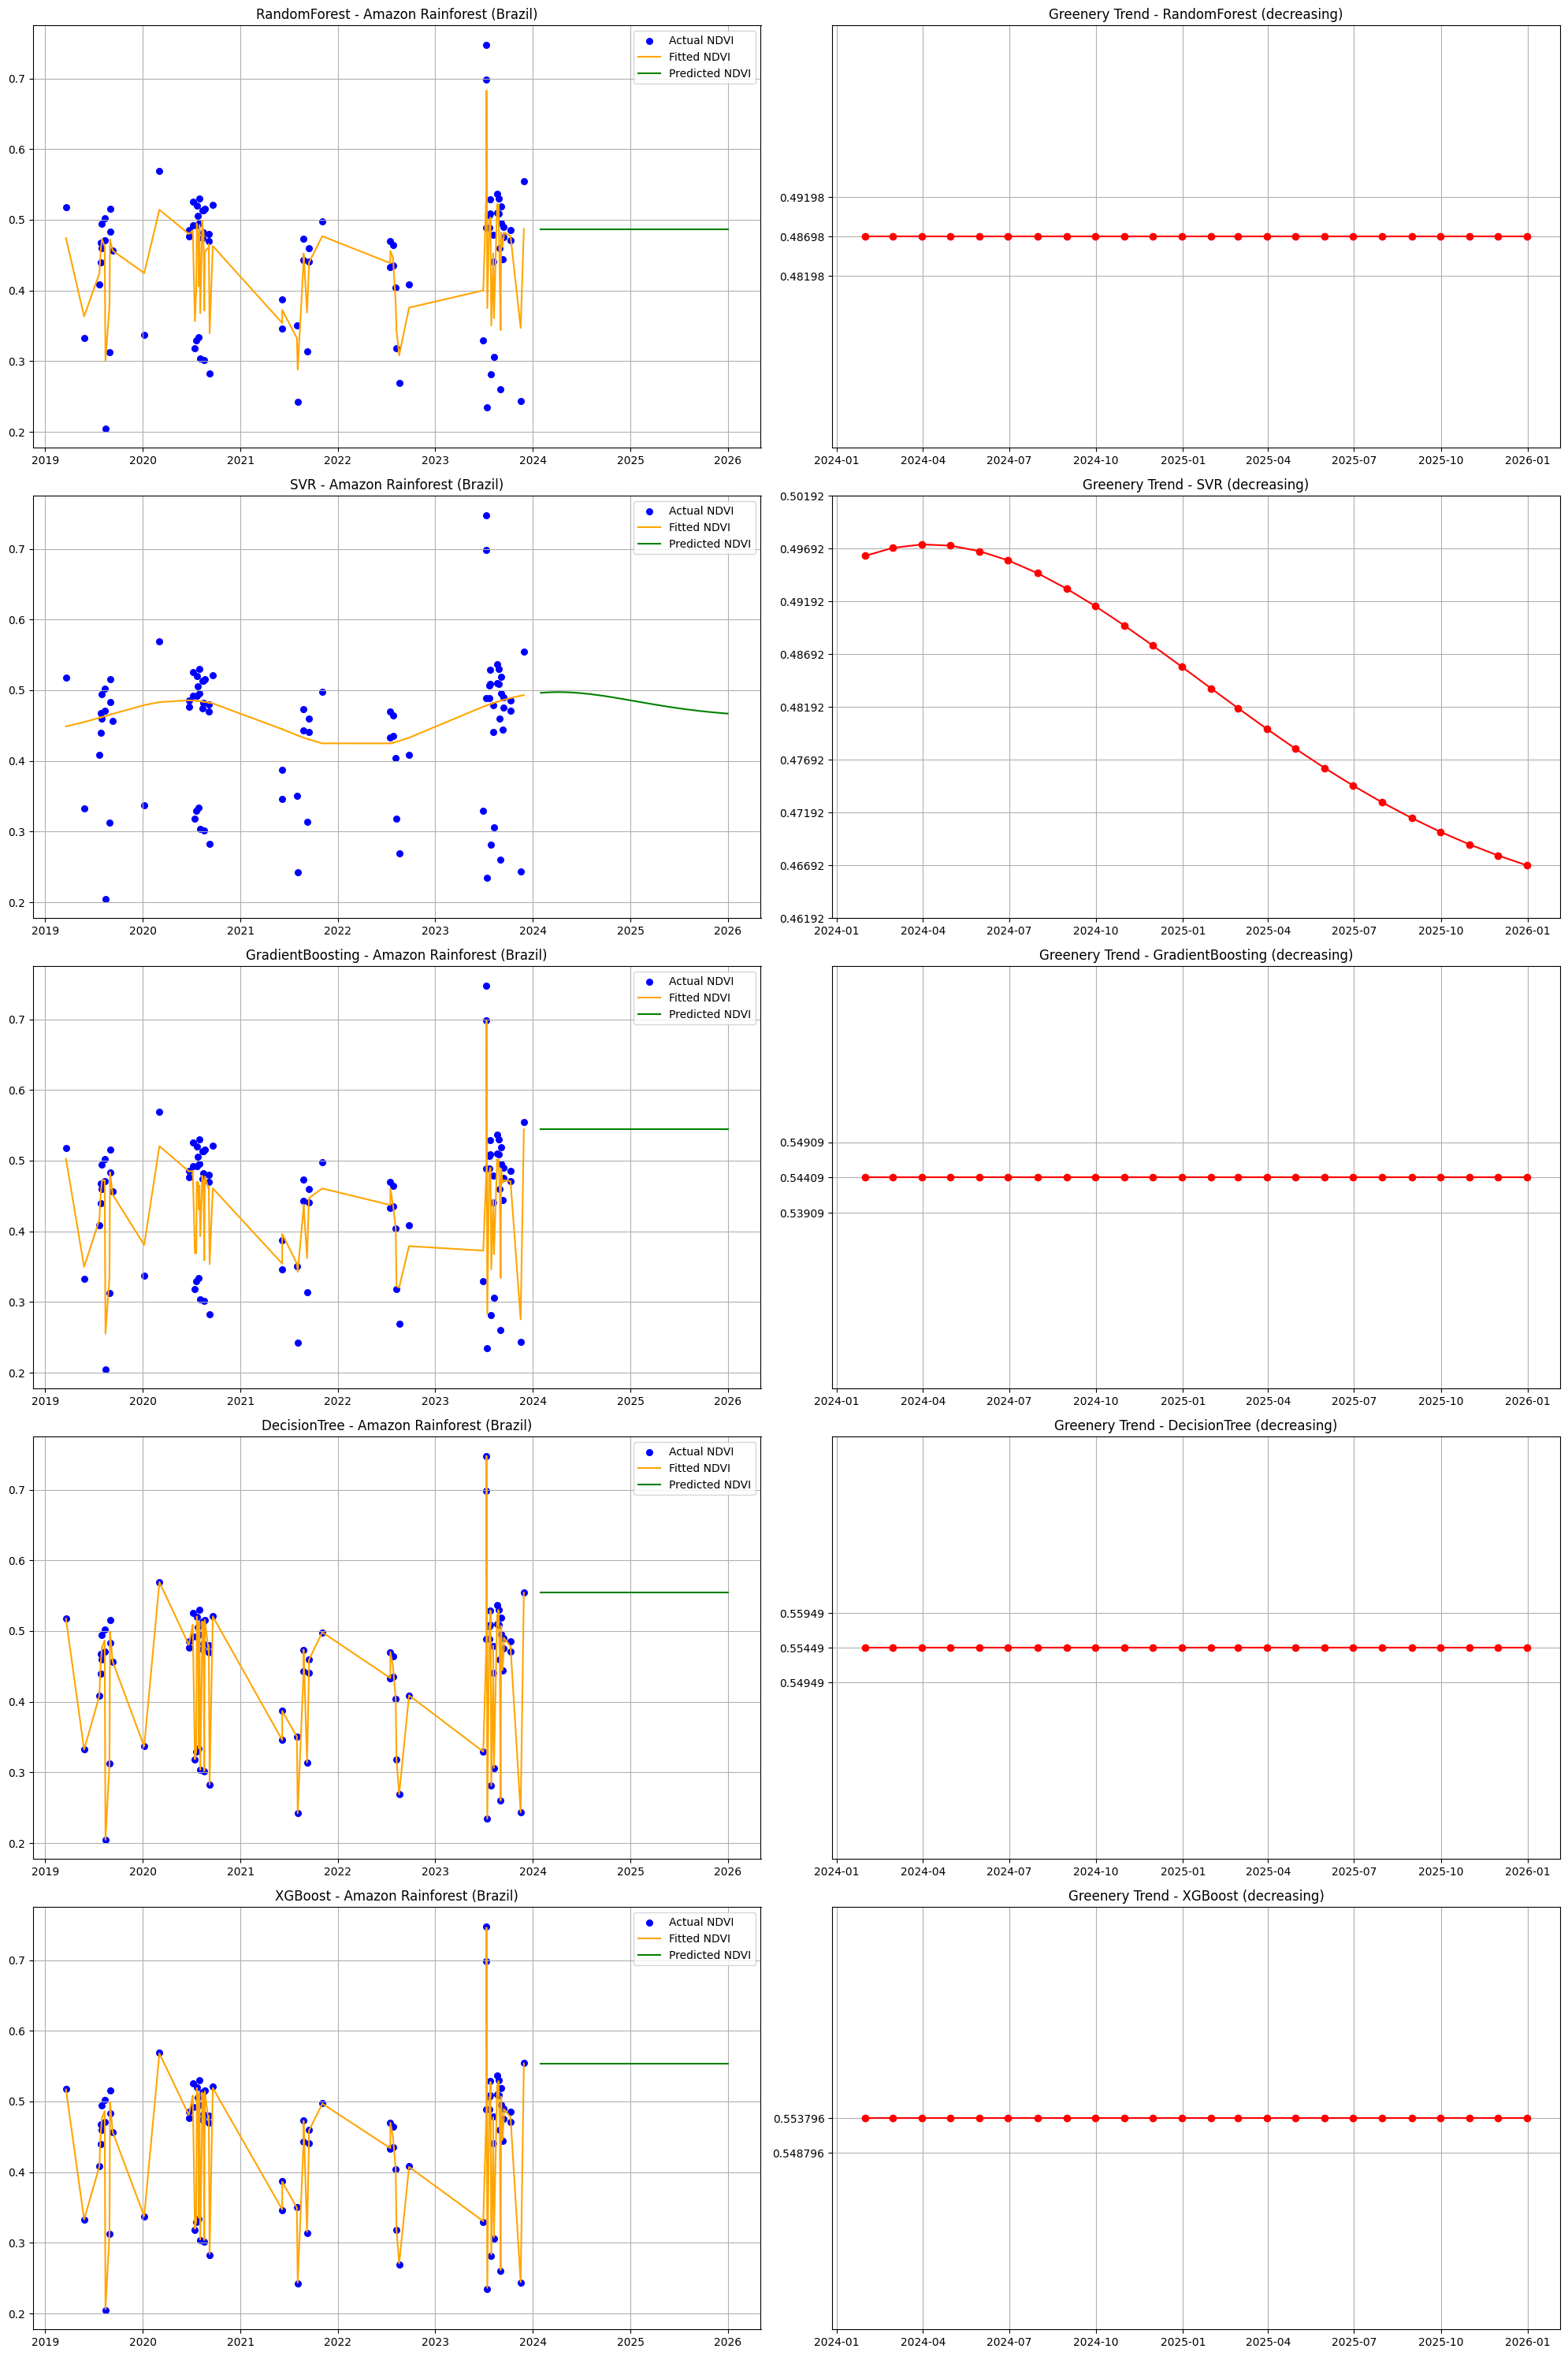

🌿 Greenery Trend for Ganges Delta (India/Bangladesh) based on Training Data: decreasing


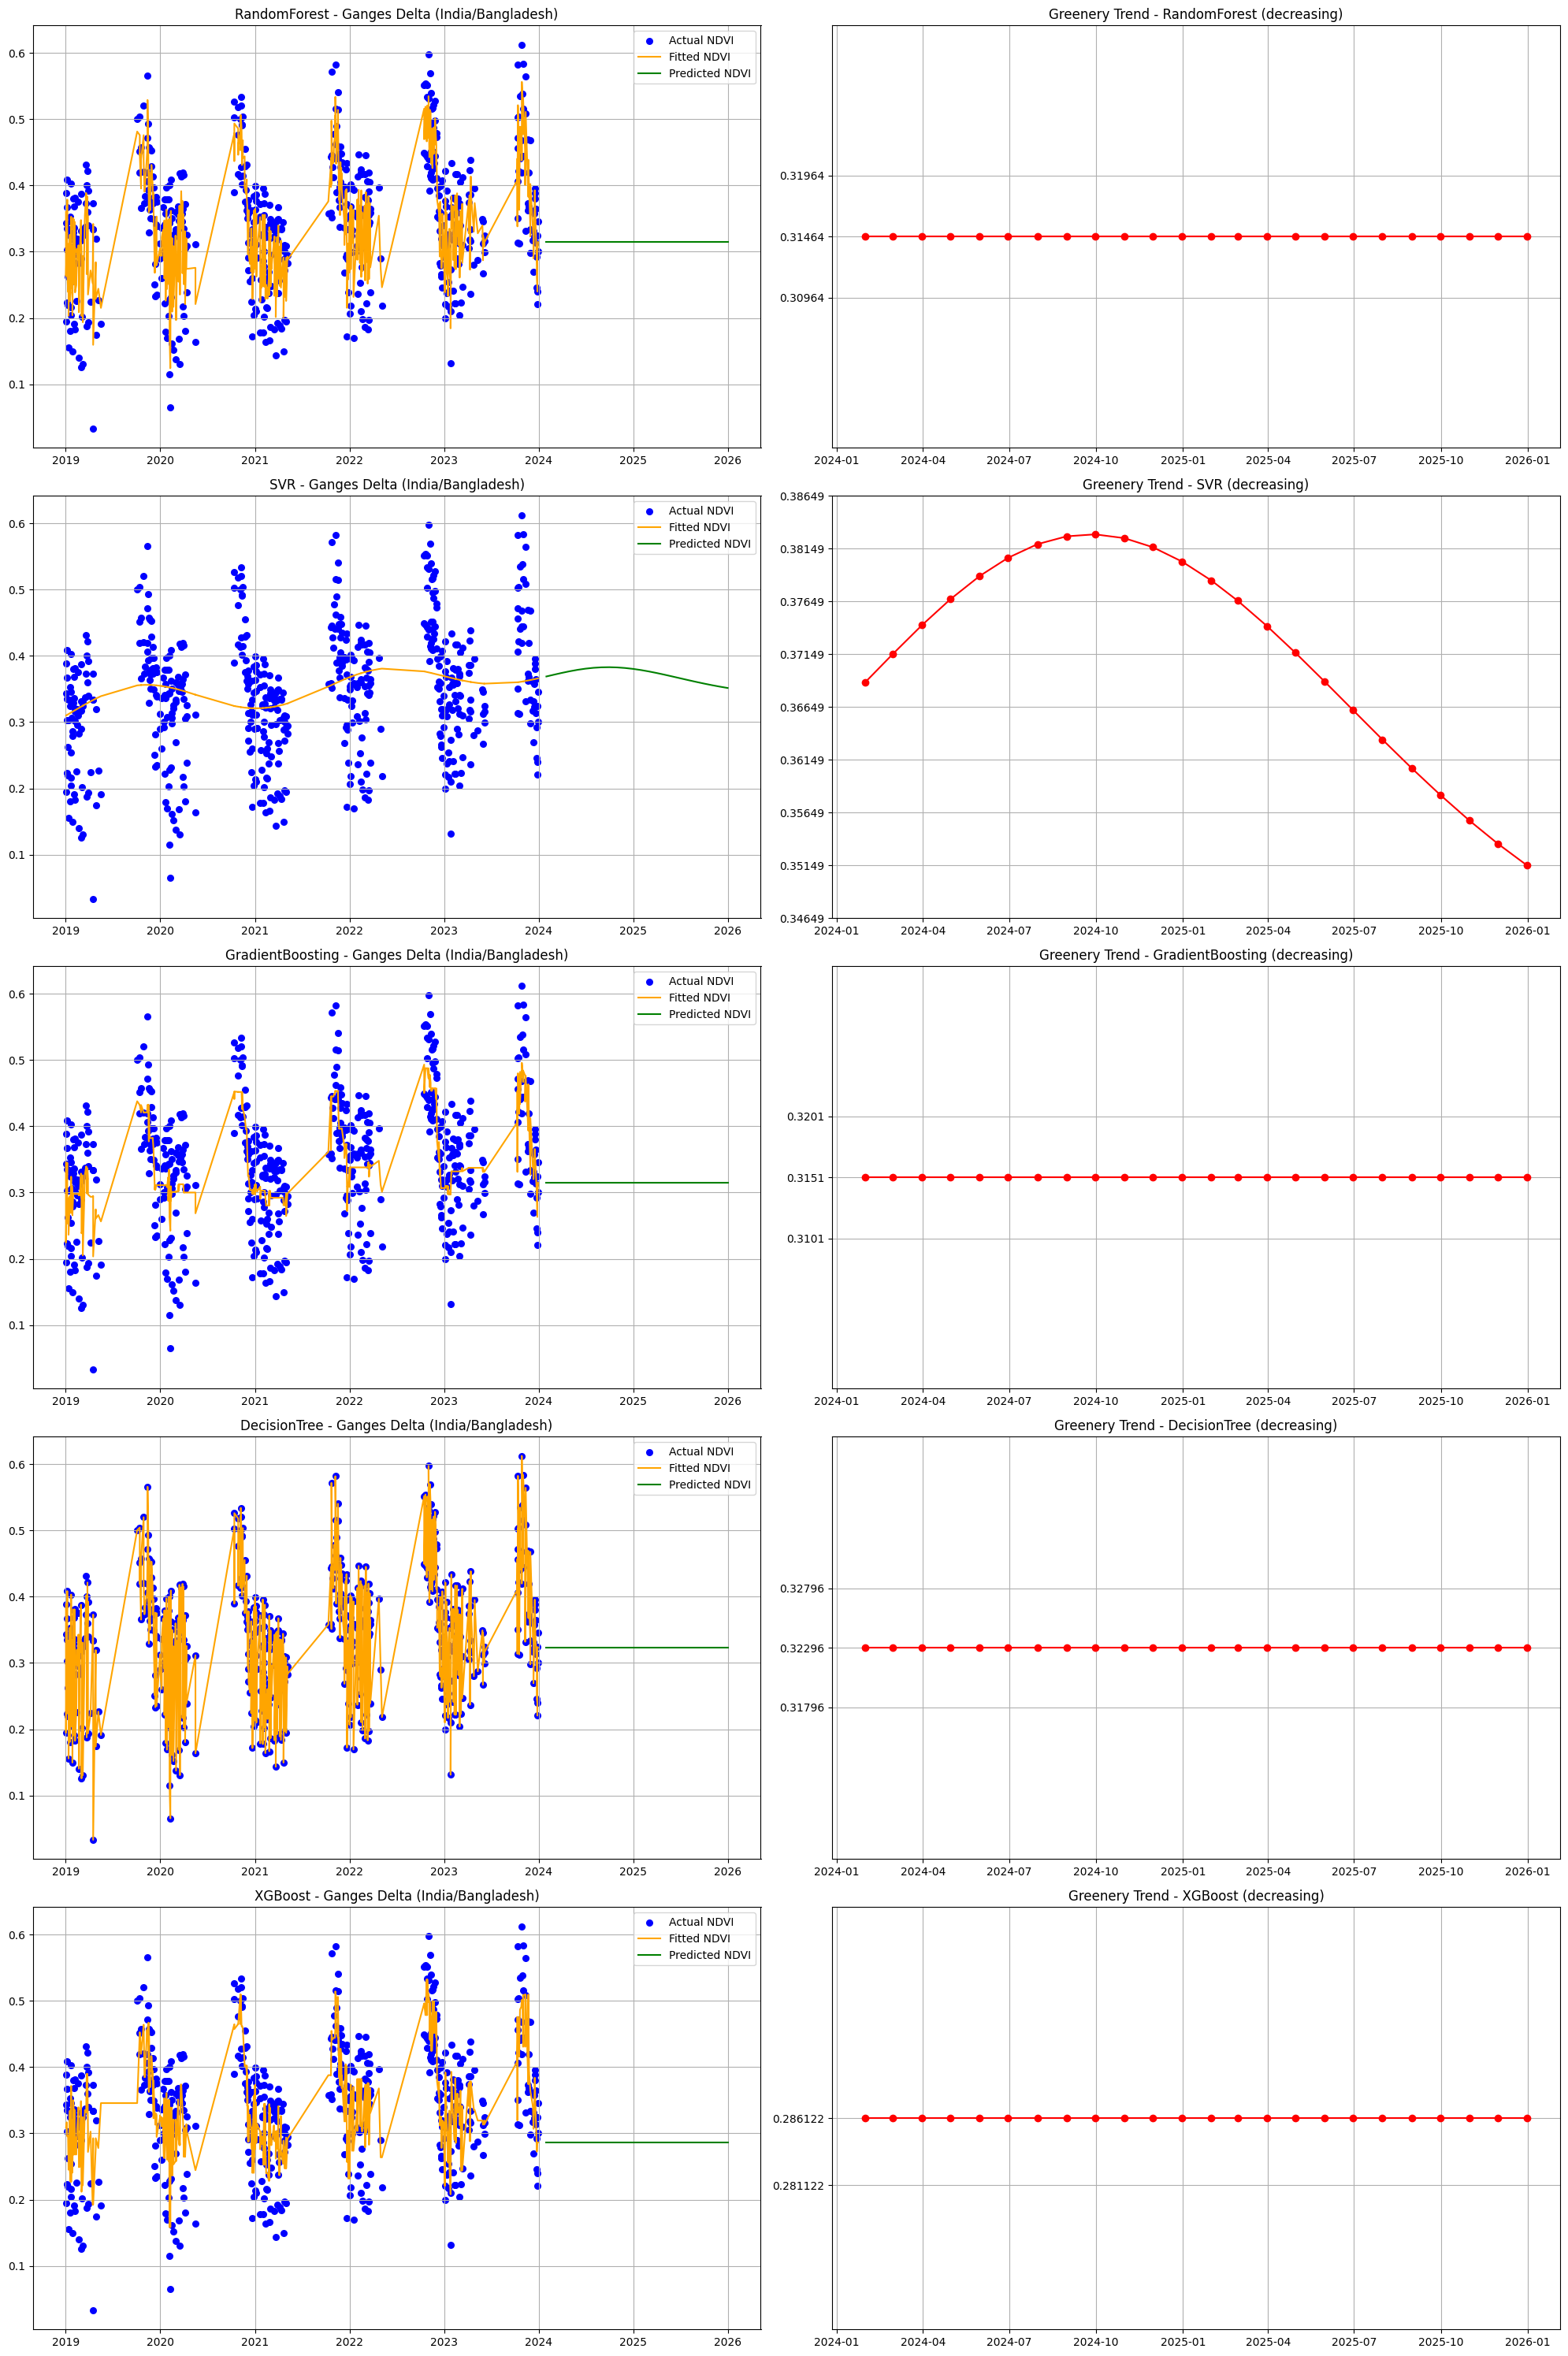

In [15]:
if __name__ == "__main__":
  locations = {
    'Amazon Rainforest (Brazil)': [-3.5, -60.0, -3.0, -59.5],
    'Ganges Delta (India/Bangladesh)': [22.0, 89.0, 22.5, 89.5],
  }

  analyzer = GreenAreaAnalyzer(locations)
  analyzer.plot_and_predict()

🔚 Conclusion

After evaluating multiple regression models — including Random Forest, Gradient Boosting, Decision Tree, XGBoost, and SVR — on historical NDVI data, we observed that **Support Vector Regressor (SVR)** consistently produced the most accurate and stable predictions for future green area trends.

📌 Key Points:
- SVR handled the temporal NDVI data smoothly, even when values were sparse or noisy.
- It showed the best balance between underfitting and overfitting.
- Visual inspection of predicted NDVI curves from SVR showed a better fit to actual values and more realistic future trends compared to the other models.

Therefore, **SVR is the recommended model for forecasting NDVI-based vegetation trends** in this project.

Note: Model performance may vary based on region, resolution, or vegetation type — further fine-tuning and cross-validation are encouraged for production use.
